# 3層ANNによる非線形歪補償
最も基本的な、入力層・中間層・出力層からなる3層ANNによる補償

In [3]:
#import
import sys
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preprocessing

## 1.1 データの整形

In [4]:
def data_shaping(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [103]:
def data_shaping2(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real - input_signal[j].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag - input_signal[j].imag
        y[i, 0] = input_signal[j].real - input_signal[j].real
        y[i, 1] = input_signal[j].imag - input_signal[j].imag
    return x, y

In [107]:
#動作確認
tap = 29
max_tap = 51

df_dir = '../data/input/prbs.csv'
df = pd.read_csv(df_dir, index_col=0)  # dataframe読み込み
condition = (df['N']==13) & (df['itr']==1) & (df['form']=='RZ16QAM') & (df['n']==32) & (df['equalize']==False) & (df['baudrate']==28) & (df['PdBm']==1)
sgnl = load_pickle(df[condition].iloc[0]['data_path'])  # dataframeから条件と合う行を取得し,pickleの保存先(data_path)にアクセス
lc = sgnl.linear_compensation(500, sgnl.signal['x_500'])
x, y = data_shaping2(sgnl.signal['x_0'][16::32], lc[16::32], max_tap, tap)  # ANNに入力できるようにデータを整形

print('x size: ', x.shape)
print('y size: ', y.shape)
print(x[0])
print(y[0])

x size:  (1998, 58)
y size:  (1998, 2)
[ 122073.71248018  -76895.01777447   38329.10847588   73016.78389501
   39868.58160496   71791.93729904  102978.56559676   -9581.13199886
   78723.57942451   49900.16097891   99582.64380303   -8682.91604546
   -7806.03250073   -8124.85942929   -6130.48948581  -10700.41668101
  139820.91316654  -32221.20373515  107407.54832772  -12335.262423
   83530.96713849  -56338.38686943   81085.85483221  -58455.03500952
   -3019.77143879  -16301.62325537   20614.43170419   30636.86896402
   17455.00177471   30178.61318274  102749.59181866 -114573.05006738
   56089.01540369    6850.25457188   22844.21477036   25744.30582796
   58928.28799471  -98512.00564643   59200.09356176    7938.72152509
   18713.74672411   29148.43860649  -21604.78142748  -51891.71692434
   16300.5833543    27084.75980359    3420.40838015   -8178.2385842
  166509.75155902    9751.22468861  120629.86096627  -73162.79408208
  -23450.58492712  -57747.80661272   40028.38986819  -36540.3646341

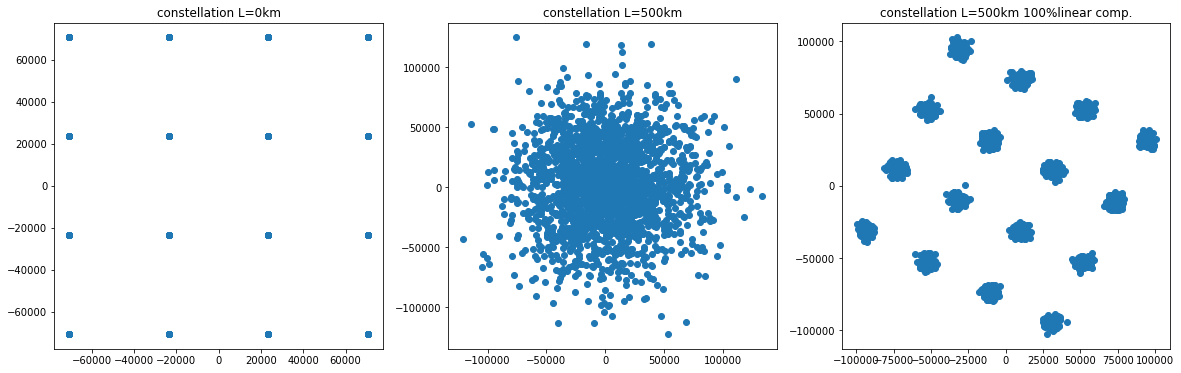

In [108]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(sgnl.signal['x_0'][16::32].real, sgnl.signal['x_0'][16::32].imag, 'o')
ax1.set_title('constellation L=0km')

ax2.plot(sgnl.signal['x_500'][16::32].real, sgnl.signal['x_500'][16::32].imag, 'o')
ax2.set_title('constellation L=500km')

ax3.plot(lc[16::32].real, lc[16::32].imag, 'o')
ax3.set_title('constellation L=500km 100%linear comp.');

## 1.2 平均,標準偏差の計算

In [109]:
mean = np.mean(x)
std = np.std(x)

print('mean: ', mean)
print('std: ', std)

mean:  483.09034297663067
std:  72712.07475468544


# 2. Dataset定義

In [5]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

In [111]:
#動作確認
train_dataset = Dataset(x=x, y=y, mean=mean, std=std)

index = 0
x_normalized, y_normalized = train_dataset.__getitem__(index)
x_array = x_normalized.detach().numpy()

print('mean: ', np.mean(x_array))
print('std: ', np.std(x_array))
print(x_normalized)
print(y_normalized)

mean:  0.27655828
std:  0.8249099
tensor([ 1.6722, -1.0642,  0.5205,  0.9975,  0.5417,  0.9807,  1.4096, -0.1384,
         1.0760,  0.6796,  1.3629, -0.1261, -0.1140, -0.1184, -0.0910, -0.1538,
         1.9163, -0.4498,  1.4705, -0.1763,  1.1421, -0.7815,  1.1085, -0.8106,
        -0.0482, -0.2308,  0.2769,  0.4147,  0.2334,  0.4084,  1.4065, -1.5824,
         0.7647,  0.0876,  0.3075,  0.3474,  0.8038, -1.3615,  0.8075,  0.1025,
         0.2507,  0.3942, -0.3038, -0.7203,  0.2175,  0.3658,  0.0404, -0.1191,
         2.2833,  0.1275,  1.6524, -1.0128, -0.3292, -0.8008,  0.5439, -0.5092,
         1.0959, -0.7286])
tensor([-0.0066, -0.0066])


In [112]:
batch_size = 100

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader}

# 3. Model定義

In [6]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [114]:
#動作確認
hidden_neuron = 300
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron).to(device)
for x, y in train_dataloader:
    output = model(x)
    print(output[:6])
    break

Device available now: cpu
tensor([[ 0.3180,  0.0384],
        [ 0.4322,  0.0349],
        [ 0.6066, -0.3669],
        [ 0.3685, -0.3020],
        [ 0.0462, -0.0678],
        [ 0.5250, -0.3377]], grad_fn=<SliceBackward>)


# 4. train定義

In [7]:
def evm_score(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    evm = torch.sqrt(tmp / len(y_pred))
    return evm

In [8]:
def train_model(device, model, dataloaders_dict, criterion, optimizer, epochs, epochs_section=None):
    for epoch in range(epochs):
        if epochs_section is not None:
            epoch += epochs_section[0]
            end_epoch = epochs_section[1]
        else:
            end_epoch = epochs
        
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                x = x.to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms += (evm_score(outputs, y)) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, end_epoch, phase, epoch_loss, epoch_evm))
    return model

In [119]:
#動作確認
epochs = 5
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs);

0:00:00 | Epoch: 1/5 | train Loss: 0.02162 | EVM: 2.213e+03
0:00:00 | Epoch: 2/5 | train Loss: 0.005235 | EVM: 1.089e+03
0:00:00 | Epoch: 3/5 | train Loss: 0.003076 | EVM: 834.7
0:00:00 | Epoch: 4/5 | train Loss: 0.002175 | EVM: 701.9
0:00:00 | Epoch: 5/5 | train Loss: 0.001783 | EVM: 635.5


# 5. 実行

In [81]:
#結果を保存しない
tap = 201
max_tap = 501
batch_size = 100
hidden_neuron = 300
epochs = 500
lr = 0.001

device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

df_dir = '../data/input/'
df0 = pd.read_csv(df_dir+'prbs.csv', index_col=0)

condition0 = (df0['N']==13) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl0 = load_pickle(df0[condition0].iloc[0]['data_path'])
lc0 = sgnl0.linear_compensation(2500, sgnl0.signal['x_2500'])
x0, y0 = data_shaping(sgnl0.signal['x_0'][16::32], lc0[16::32], max_tap, tap)

condition1 = (df0['N']==17) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl1 = load_pickle(df0[condition1].iloc[0]['data_path'])
lc1 = sgnl1.linear_compensation(2500, sgnl1.signal['x_2500'])
x1, y1 = data_shaping(sgnl1.signal['x_0'][16::32], lc1[16::32], max_tap, tap)

mean = np.mean(x0)
std = np.std(x0)

train_dataset = Dataset(x=x0, y=y0, mean=mean, std=std)
val_dataset = Dataset(x=x1, y=y1, mean=mean, std=std)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)

Device available now: cpu
0:00:00 | Epoch: 1/500 | train Loss: 1.025 | EVM: 103.9
0:00:05 | Epoch: 1/500 | val Loss: 0.9298 | EVM: 98.28
0:00:00 | Epoch: 2/500 | train Loss: 0.597 | EVM: 79.57
0:00:05 | Epoch: 2/500 | val Loss: 0.8148 | EVM: 93.7
0:00:00 | Epoch: 3/500 | train Loss: 0.3386 | EVM: 62.73
0:00:05 | Epoch: 3/500 | val Loss: 0.6996 | EVM: 89.65
0:00:00 | Epoch: 4/500 | train Loss: 0.1544 | EVM: 46.09
0:00:06 | Epoch: 4/500 | val Loss: 0.566 | EVM: 82.64
0:00:00 | Epoch: 5/500 | train Loss: 0.04961 | EVM: 27.83
0:00:05 | Epoch: 5/500 | val Loss: 0.4524 | EVM: 74.16
0:00:00 | Epoch: 6/500 | train Loss: 0.01432 | EVM: 15.87
0:00:06 | Epoch: 6/500 | val Loss: 0.3871 | EVM: 68.05
0:00:00 | Epoch: 7/500 | train Loss: 0.005133 | EVM: 9.67
0:00:06 | Epoch: 7/500 | val Loss: 0.3719 | EVM: 66.46
0:00:00 | Epoch: 8/500 | train Loss: 0.002005 | EVM: 6.008
0:00:06 | Epoch: 8/500 | val Loss: 0.3748 | EVM: 66.7
0:00:00 | Epoch: 9/500 | train Loss: 0.0006913 | EVM: 3.606
0:00:06 | Epoch: 9

0:00:06 | Epoch: 71/500 | val Loss: 0.3168 | EVM: 61.2
0:00:00 | Epoch: 72/500 | train Loss: 0.0003631 | EVM: 2.656
0:00:06 | Epoch: 72/500 | val Loss: 0.318 | EVM: 61.2
0:00:00 | Epoch: 73/500 | train Loss: 0.0002599 | EVM: 2.215
0:00:06 | Epoch: 73/500 | val Loss: 0.3165 | EVM: 61.13
0:00:00 | Epoch: 74/500 | train Loss: 0.0001904 | EVM: 1.912
0:00:07 | Epoch: 74/500 | val Loss: 0.3174 | EVM: 61.15
0:00:00 | Epoch: 75/500 | train Loss: 0.0001514 | EVM: 1.702
0:00:06 | Epoch: 75/500 | val Loss: 0.3168 | EVM: 61.14
0:00:00 | Epoch: 76/500 | train Loss: 0.0001251 | EVM: 1.536
0:00:06 | Epoch: 76/500 | val Loss: 0.317 | EVM: 61.12
0:00:00 | Epoch: 77/500 | train Loss: 0.000106 | EVM: 1.431
0:00:06 | Epoch: 77/500 | val Loss: 0.3168 | EVM: 61.15
0:00:00 | Epoch: 78/500 | train Loss: 9.006e-05 | EVM: 1.335
0:00:06 | Epoch: 78/500 | val Loss: 0.317 | EVM: 61.13
0:00:00 | Epoch: 79/500 | train Loss: 7.409e-05 | EVM: 1.172
0:00:06 | Epoch: 79/500 | val Loss: 0.3167 | EVM: 61.13
0:00:00 | Epoc

0:00:06 | Epoch: 141/500 | val Loss: 0.2792 | EVM: 57.36
0:00:00 | Epoch: 142/500 | train Loss: 0.0004364 | EVM: 2.849
0:00:06 | Epoch: 142/500 | val Loss: 0.2781 | EVM: 57.25
0:00:00 | Epoch: 143/500 | train Loss: 0.0004044 | EVM: 2.83
0:00:06 | Epoch: 143/500 | val Loss: 0.2792 | EVM: 57.35
0:00:00 | Epoch: 144/500 | train Loss: 0.0004151 | EVM: 2.821
0:00:06 | Epoch: 144/500 | val Loss: 0.2792 | EVM: 57.32
0:00:00 | Epoch: 145/500 | train Loss: 0.0004389 | EVM: 2.812
0:00:06 | Epoch: 145/500 | val Loss: 0.278 | EVM: 57.25
0:00:00 | Epoch: 146/500 | train Loss: 0.0004402 | EVM: 2.897
0:00:06 | Epoch: 146/500 | val Loss: 0.2778 | EVM: 57.23
0:00:00 | Epoch: 147/500 | train Loss: 0.0005001 | EVM: 3.079
0:00:06 | Epoch: 147/500 | val Loss: 0.2783 | EVM: 57.26
0:00:00 | Epoch: 148/500 | train Loss: 0.0005628 | EVM: 3.197
0:00:06 | Epoch: 148/500 | val Loss: 0.2788 | EVM: 57.3
0:00:00 | Epoch: 149/500 | train Loss: 0.0006054 | EVM: 3.404
0:00:06 | Epoch: 149/500 | val Loss: 0.2786 | EVM: 

0:00:06 | Epoch: 211/500 | val Loss: 0.2362 | EVM: 52.79
0:00:00 | Epoch: 212/500 | train Loss: 0.002182 | EVM: 6.531
0:00:07 | Epoch: 212/500 | val Loss: 0.2365 | EVM: 52.93
0:00:00 | Epoch: 213/500 | train Loss: 0.002344 | EVM: 6.735
0:00:06 | Epoch: 213/500 | val Loss: 0.2361 | EVM: 52.89
0:00:00 | Epoch: 214/500 | train Loss: 0.002369 | EVM: 6.911
0:00:06 | Epoch: 214/500 | val Loss: 0.2362 | EVM: 52.84
0:00:00 | Epoch: 215/500 | train Loss: 0.002289 | EVM: 6.524
0:00:06 | Epoch: 215/500 | val Loss: 0.237 | EVM: 52.84
0:00:00 | Epoch: 216/500 | train Loss: 0.002171 | EVM: 6.475
0:00:06 | Epoch: 216/500 | val Loss: 0.2361 | EVM: 52.83
0:00:00 | Epoch: 217/500 | train Loss: 0.002168 | EVM: 6.488
0:00:06 | Epoch: 217/500 | val Loss: 0.2341 | EVM: 52.55
0:00:00 | Epoch: 218/500 | train Loss: 0.002131 | EVM: 6.372
0:00:06 | Epoch: 218/500 | val Loss: 0.2336 | EVM: 52.59
0:00:00 | Epoch: 219/500 | train Loss: 0.002183 | EVM: 6.493
0:00:07 | Epoch: 219/500 | val Loss: 0.2329 | EVM: 52.44


0:00:05 | Epoch: 281/500 | val Loss: 0.1968 | EVM: 48.57
0:00:00 | Epoch: 282/500 | train Loss: 0.002228 | EVM: 6.34
0:00:05 | Epoch: 282/500 | val Loss: 0.1963 | EVM: 48.44
0:00:00 | Epoch: 283/500 | train Loss: 0.002027 | EVM: 6.111
0:00:04 | Epoch: 283/500 | val Loss: 0.194 | EVM: 48.23
0:00:00 | Epoch: 284/500 | train Loss: 0.00197 | EVM: 5.961
0:00:05 | Epoch: 284/500 | val Loss: 0.195 | EVM: 48.32
0:00:00 | Epoch: 285/500 | train Loss: 0.001896 | EVM: 5.848
0:00:05 | Epoch: 285/500 | val Loss: 0.1947 | EVM: 48.23
0:00:00 | Epoch: 286/500 | train Loss: 0.001766 | EVM: 5.805
0:00:04 | Epoch: 286/500 | val Loss: 0.1959 | EVM: 48.34
0:00:00 | Epoch: 287/500 | train Loss: 0.001748 | EVM: 5.909
0:00:05 | Epoch: 287/500 | val Loss: 0.1951 | EVM: 48.24
0:00:00 | Epoch: 288/500 | train Loss: 0.001696 | EVM: 5.743
0:00:04 | Epoch: 288/500 | val Loss: 0.1947 | EVM: 48.19
0:00:00 | Epoch: 289/500 | train Loss: 0.001587 | EVM: 5.609
0:00:04 | Epoch: 289/500 | val Loss: 0.1927 | EVM: 47.96
0:0

0:00:05 | Epoch: 351/500 | val Loss: 0.1672 | EVM: 44.87
0:00:00 | Epoch: 352/500 | train Loss: 0.00194 | EVM: 6.164
0:00:05 | Epoch: 352/500 | val Loss: 0.1684 | EVM: 45.02
0:00:00 | Epoch: 353/500 | train Loss: 0.002196 | EVM: 6.531
0:00:05 | Epoch: 353/500 | val Loss: 0.1706 | EVM: 45.25
0:00:00 | Epoch: 354/500 | train Loss: 0.002309 | EVM: 6.592
0:00:05 | Epoch: 354/500 | val Loss: 0.1675 | EVM: 44.9
0:00:00 | Epoch: 355/500 | train Loss: 0.002484 | EVM: 6.917
0:00:04 | Epoch: 355/500 | val Loss: 0.1672 | EVM: 44.95
0:00:00 | Epoch: 356/500 | train Loss: 0.002472 | EVM: 6.994
0:00:05 | Epoch: 356/500 | val Loss: 0.1646 | EVM: 44.55
0:00:00 | Epoch: 357/500 | train Loss: 0.002319 | EVM: 6.729
0:00:05 | Epoch: 357/500 | val Loss: 0.1629 | EVM: 44.5
0:00:00 | Epoch: 358/500 | train Loss: 0.002341 | EVM: 6.64
0:00:05 | Epoch: 358/500 | val Loss: 0.1653 | EVM: 44.65
0:00:00 | Epoch: 359/500 | train Loss: 0.002856 | EVM: 7.229
0:00:05 | Epoch: 359/500 | val Loss: 0.1642 | EVM: 44.48
0:0

0:00:05 | Epoch: 421/500 | val Loss: 0.1414 | EVM: 41.5
0:00:00 | Epoch: 422/500 | train Loss: 0.001038 | EVM: 4.537
0:00:05 | Epoch: 422/500 | val Loss: 0.139 | EVM: 41.2
0:00:00 | Epoch: 423/500 | train Loss: 0.001029 | EVM: 4.427
0:00:05 | Epoch: 423/500 | val Loss: 0.1422 | EVM: 41.59
0:00:00 | Epoch: 424/500 | train Loss: 0.001032 | EVM: 4.329
0:00:05 | Epoch: 424/500 | val Loss: 0.1378 | EVM: 41.12
0:00:00 | Epoch: 425/500 | train Loss: 0.00104 | EVM: 4.341
0:00:05 | Epoch: 425/500 | val Loss: 0.1417 | EVM: 41.5
0:00:00 | Epoch: 426/500 | train Loss: 0.001027 | EVM: 4.273
0:00:05 | Epoch: 426/500 | val Loss: 0.1383 | EVM: 41.12
0:00:00 | Epoch: 427/500 | train Loss: 0.0009316 | EVM: 4.202
0:00:05 | Epoch: 427/500 | val Loss: 0.1389 | EVM: 41.23
0:00:00 | Epoch: 428/500 | train Loss: 0.0009199 | EVM: 4.225
0:00:05 | Epoch: 428/500 | val Loss: 0.1396 | EVM: 41.27
0:00:00 | Epoch: 429/500 | train Loss: 0.0009638 | EVM: 4.196
0:00:05 | Epoch: 429/500 | val Loss: 0.1395 | EVM: 41.22
0

0:00:00 | Epoch: 491/500 | train Loss: 0.001307 | EVM: 4.797
0:00:04 | Epoch: 491/500 | val Loss: 0.1249 | EVM: 39.31
0:00:00 | Epoch: 492/500 | train Loss: 0.001275 | EVM: 4.763
0:00:04 | Epoch: 492/500 | val Loss: 0.1241 | EVM: 39.16
0:00:00 | Epoch: 493/500 | train Loss: 0.001233 | EVM: 4.77
0:00:05 | Epoch: 493/500 | val Loss: 0.1237 | EVM: 39.08
0:00:00 | Epoch: 494/500 | train Loss: 0.001243 | EVM: 4.763
0:00:04 | Epoch: 494/500 | val Loss: 0.1225 | EVM: 39.03
0:00:00 | Epoch: 495/500 | train Loss: 0.001263 | EVM: 4.857
0:00:04 | Epoch: 495/500 | val Loss: 0.1254 | EVM: 39.31
0:00:00 | Epoch: 496/500 | train Loss: 0.001367 | EVM: 5.014
0:00:04 | Epoch: 496/500 | val Loss: 0.1218 | EVM: 38.87
0:00:00 | Epoch: 497/500 | train Loss: 0.001376 | EVM: 5.059
0:00:04 | Epoch: 497/500 | val Loss: 0.124 | EVM: 39.15
0:00:00 | Epoch: 498/500 | train Loss: 0.001497 | EVM: 5.292
0:00:04 | Epoch: 498/500 | val Loss: 0.1215 | EVM: 38.82
0:00:00 | Epoch: 499/500 | train Loss: 0.001601 | EVM: 5.3

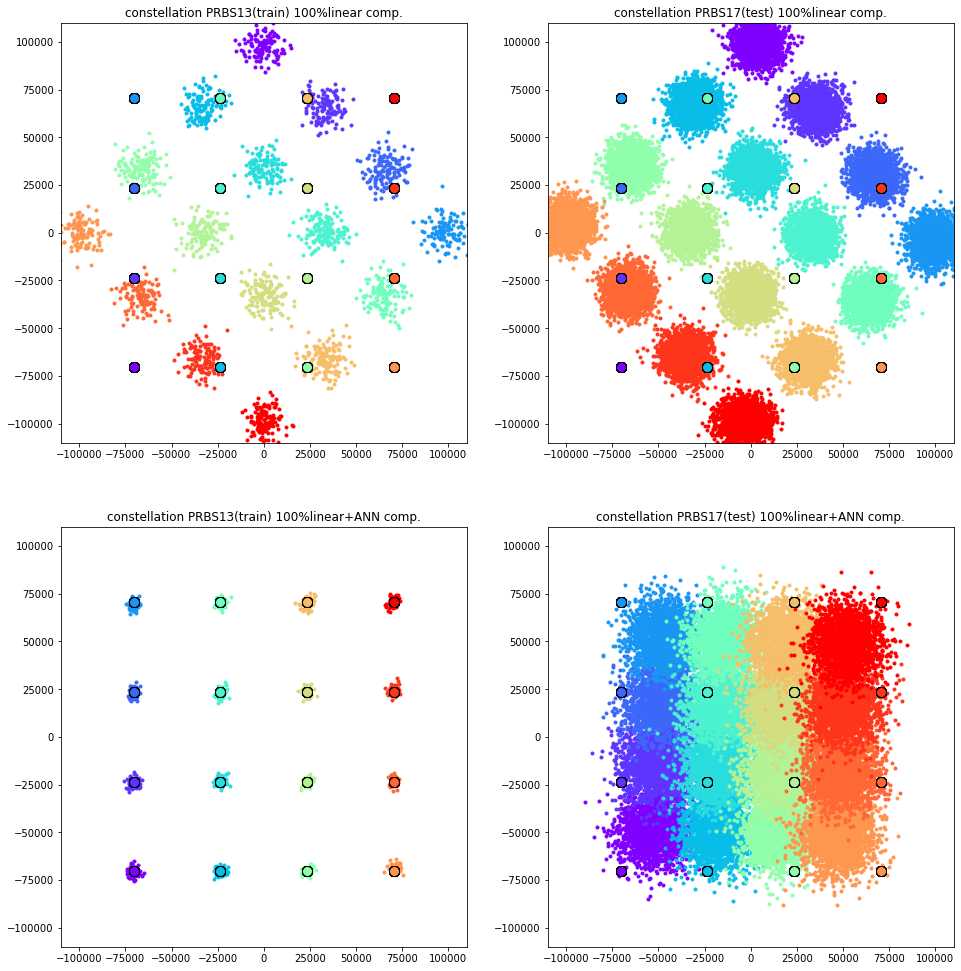

In [82]:
#可視化
annc0 = model(train_dataset[:][0]).detach().numpy()
annc0 = annc0 * std + mean
annc0 = annc0[:, 0] + annc0[:, 1] * 1j
y0 = train_dataset[:][1].detach().numpy()
y0 = y0 * std + mean
y0 = y0.astype(np.int32)
y0 = y0[:, 0] + y0[:, 1] * 1j
annc1 = model(val_dataset[:][0]).detach().numpy()
annc1 = annc1 * std + mean
annc1 = annc1[:, 0] + annc1[:, 1] * 1j
y1 = val_dataset[:][1].detach().numpy()
y1 = y1 * std + mean
y1 = y1.astype(np.int32)
y1 = y1[:, 0] + y1[:, 1] * 1j

lim = 110000
cm = plt.get_cmap('rainbow', 16)

seq0 = sgnl0.signal['x_0'][16::32]
seq1 = sgnl1.signal['x_0'][16::32]
symbol, inverse, counts = np.unique(seq0, return_inverse=True, return_counts=True)
symbol_int = symbol.real.astype(np.int32) + symbol.imag.astype(np.int32) * 1j

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for i in range(len(symbol)):
    ax1.plot(lc0[16::32][seq0 == symbol[i]].real, lc0[16::32][seq0 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax1.plot(seq0[seq0 == symbol[i]].real, seq0[seq0 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax2.plot(lc1[16::32][seq1 == symbol[i]].real, lc1[16::32][seq1 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax2.plot(seq1[seq1 == symbol[i]].real, seq1[seq1 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax3.plot(annc0[y0 == symbol_int[i]].real, annc0[y0 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax3.plot(y0[y0 == symbol_int[i]].real, y0[y0 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax4.plot(annc1[y1 == symbol_int[i]].real, annc1[y1 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax4.plot(y1[y1 == symbol_int[i]].real, y1[y1 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);

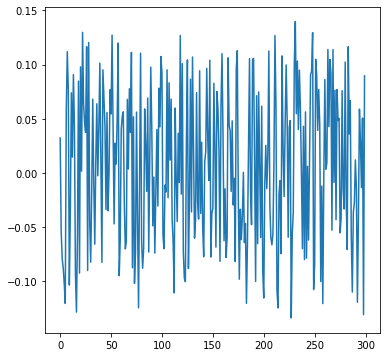

In [129]:
#重み可視化
weight = model.state_dict()['fc1.weight'].detach().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(weight[:, 0])

In [53]:
def train_ann(tap, PdBm):
    #結果と条件を../data/params/ANN.csvに保存する
    #tap = 1
    max_tap = 501
    batch_size = 100
    neuron = 300
    epochs = 500
    lr = 0.001

    device = torch.device('cpu') #'cuda' if torch.cuda.is_available() else 
    print('Device available now:', device)

    signal_type = 'image'

    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    #PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 2500  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか

    if signal_type == 'prbs':
        N = 13  # PRBSの次数
        itr = 1  # PRBSの繰り返し回数
    elif signal_type == 'random':
        seed = 1234  # 乱数シード
        bit_num = 100000  # ビット長を指定
    elif signal_type == 'image':
        target_dir = 'train_0'
        step = 10  # =10 ---> (768, 1024) ---> (76, 102)
        image_number = '0, 5, 6, 12, 17, 33, 35, 45, 52, 53'
        image_number_split = image_number.split(', ')
        ebtb = True  # 8B10Bを行うか

    # prbs.csv or random.csv or image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

    # if ANN.csv がある: pandasで読み込む if ANN.csvがない: 新しいDataFrameを作る
    l_df_dir = '../data/params/ANN.csv'
    if os.path.exists(l_df_dir):
        l_df = pd.read_csv(l_df_dir, index_col=0)
    else:
        cols = ['tap', 'max_tap', 'batch_size', 'neuron', 'epochs', 'learning_rate', 'N', 'itr', 'seed', 'bit_num', 'target_dir', 'step', 'image_number', 'ebtb', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'params_path', 'train_samples']
        l_df = pd.DataFrame(index=[], columns=cols)
        l_df.to_csv(l_df_dir)

    # 指定した学習条件と伝送条件
    l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)
    t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                            gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    if signal_type == 'prbs':
        condition_t = 'N=='+str(N)+'&itr=='+str(itr)
        condition_l = condition_t
        condition_list = [N, itr] + [None] * 6
    elif signal_type == 'random':
        condition_t = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
        condition_l = condition_t
        condition_list = [None] * 2 + [seed, bit_num] + [None] * 4
    elif signal_type == 'image':
        condition_t = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[0]+'&ebtb=='+str(ebtb)
        condition_l = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
        condition_list = [None] * 4 + [target_dir, step, image_number, ebtb]

    # prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(condition_t + '&' + t_condition)

    # ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(l_condition + '&' + condition_l + '&' + t_condition + '&Lmax=='+str(Lmax))

    # 後で異なる値が代入されるもの以外をSeriesにしてしまう(epochs, params_path, train_samplesだけNone)
    sr = pd.Series([tap, max_tap, batch_size, neuron, None, lr] + condition_list + [form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, None, None], index=l_df.columns)

    #if epochsを含む指定された条件を満たす結果がある: 何もしない
    if len(l_query) > 0 and l_query['epochs'].max() >= epochs:
        print('指定された条件の学習結果はすでに存在します')
    else:
        # if epochs以外の指定された条件を満たす結果がある: パラメータを読み込む if ない: 新しくモデルを作成する
        if len(l_query) > 0:
            index = l_query['epochs'].idxmax()
            trained_epochs = l_query['epochs'][index]
            model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
            model.load_state_dict(torch.load(l_query['params_path'][index]))
        else:
            trained_epochs = 0
            model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)

        # if prbs.csv or random.csv or image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
        if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
            print('指定された伝送条件の信号が存在しません')
        else:
            # 伝送信号を学習データに整形する
            sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
            lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
            x_train, y_train = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)

            if signal_type == 'image' and len(image_number_split) > 1:
                for i in range(1, len(image_number_split)):
                    condition_t = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb)
                    t_query = t_df.query(condition_t + '&' + t_condition)
                    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
                        print('指定された伝送条件の信号が存在しません')
                        sys.exit()
                    sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
                    lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
                    x_train_tmp, y_train_tmp = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
                    x_train = np.concatenate([x_train, x_train_tmp])
                    y_train = np.concatenate([y_train, y_train_tmp])

            train_samples = len(x_train)

            # 平均,標準偏差の計算
            mean = np.mean(x_train)
            std = np.std(x_train)

            # dataset, dataloaderの作成
            train_dataset = Dataset(x=x_train, y=y_train, mean=mean, std=std)
            train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            dataloaders_dict = {'train': train_dataloader}

            # 損失関数, オプティマイザの作成
            criterion = nn.MSELoss()
            optimizer = optim.Adam(params=model.parameters(), lr=lr)

            # モデルのトレーニング(50epochsずつ学習し、50epochsずつパラメータを保存する)
            for i in range((epochs - trained_epochs) // 50):
                model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=50, epochs_section=[trained_epochs+i*50, epochs])

                # 学習済みパラメータを保存し、ANN.csvに保存先を記入する
                l_df = pd.read_csv(l_df_dir, index_col=0)
                params_path = '../data/params/ANN/params_' + str(len(l_df)).zfill(10) + '.pth'
                torch.save(model.state_dict(), params_path)
                sr[4] = trained_epochs + (i + 1) * 50
                sr[-2] = params_path
                sr[-1] = train_samples
                l_df = l_df.append(sr, ignore_index=True)
                l_df.to_csv(l_df_dir)

In [54]:
#for PdBm in [-2, -1, 0, 1, 2, 3]:
#    for tap in [1, 51, 101, 151, 201]:
train_ann(1, 1)

Device available now: cpu
0:05:31 | Epoch: 1/500 | train Loss: 0.01003 | EVM: 13.12
0:07:27 | Epoch: 2/500 | train Loss: 0.003097 | EVM: 6.617
0:05:21 | Epoch: 3/500 | train Loss: 0.002671 | EVM: 5.968
0:05:35 | Epoch: 4/500 | train Loss: 0.002548 | EVM: 5.743
0:05:59 | Epoch: 5/500 | train Loss: 0.002482 | EVM: 5.636
0:06:10 | Epoch: 6/500 | train Loss: 0.002444 | EVM: 5.571
0:06:04 | Epoch: 7/500 | train Loss: 0.002423 | EVM: 5.533
0:06:06 | Epoch: 8/500 | train Loss: 0.002396 | EVM: 5.498
0:06:06 | Epoch: 9/500 | train Loss: 0.002386 | EVM: 5.476
0:06:07 | Epoch: 10/500 | train Loss: 0.002371 | EVM: 5.454
0:05:46 | Epoch: 11/500 | train Loss: 0.002348 | EVM: 5.425
0:06:15 | Epoch: 12/500 | train Loss: 0.002346 | EVM: 5.418
0:06:07 | Epoch: 13/500 | train Loss: 0.002331 | EVM: 5.399
0:05:24 | Epoch: 14/500 | train Loss: 0.002318 | EVM: 5.389
0:05:23 | Epoch: 15/500 | train Loss: 0.002313 | EVM: 5.38
0:06:05 | Epoch: 16/500 | train Loss: 0.002303 | EVM: 5.372
0:05:56 | Epoch: 17/500 |

0:04:53 | Epoch: 138/500 | train Loss: 0.00206 | EVM: 5.146
0:04:44 | Epoch: 139/500 | train Loss: 0.002057 | EVM: 5.149
0:04:48 | Epoch: 140/500 | train Loss: 0.002061 | EVM: 5.143
0:05:07 | Epoch: 141/500 | train Loss: 0.002063 | EVM: 5.148
0:04:51 | Epoch: 142/500 | train Loss: 0.002056 | EVM: 5.141
0:04:45 | Epoch: 143/500 | train Loss: 0.002055 | EVM: 5.144
0:04:51 | Epoch: 144/500 | train Loss: 0.002056 | EVM: 5.14
0:04:57 | Epoch: 145/500 | train Loss: 0.002057 | EVM: 5.145
0:04:50 | Epoch: 146/500 | train Loss: 0.002056 | EVM: 5.142
0:04:46 | Epoch: 147/500 | train Loss: 0.002056 | EVM: 5.137
0:04:58 | Epoch: 148/500 | train Loss: 0.00205 | EVM: 5.143
0:05:05 | Epoch: 149/500 | train Loss: 0.002054 | EVM: 5.145
0:04:47 | Epoch: 150/500 | train Loss: 0.002056 | EVM: 5.149
0:04:43 | Epoch: 151/500 | train Loss: 0.002058 | EVM: 5.149
0:05:35 | Epoch: 152/500 | train Loss: 0.002056 | EVM: 5.142
0:04:41 | Epoch: 153/500 | train Loss: 0.002049 | EVM: 5.137
0:05:12 | Epoch: 154/500 | 

0:06:43 | Epoch: 273/500 | train Loss: 0.002024 | EVM: 5.129
0:06:43 | Epoch: 274/500 | train Loss: 0.00202 | EVM: 5.122
0:06:42 | Epoch: 275/500 | train Loss: 0.002019 | EVM: 5.123
0:06:43 | Epoch: 276/500 | train Loss: 0.00202 | EVM: 5.121
0:06:44 | Epoch: 277/500 | train Loss: 0.002022 | EVM: 5.127
0:06:42 | Epoch: 278/500 | train Loss: 0.002015 | EVM: 5.117
0:06:33 | Epoch: 279/500 | train Loss: 0.002022 | EVM: 5.12
0:06:18 | Epoch: 280/500 | train Loss: 0.002017 | EVM: 5.119
0:05:46 | Epoch: 281/500 | train Loss: 0.002019 | EVM: 5.127
0:06:02 | Epoch: 282/500 | train Loss: 0.002017 | EVM: 5.121
0:06:00 | Epoch: 283/500 | train Loss: 0.002017 | EVM: 5.121
0:05:59 | Epoch: 284/500 | train Loss: 0.002019 | EVM: 5.117
0:05:59 | Epoch: 285/500 | train Loss: 0.002014 | EVM: 5.118
0:05:59 | Epoch: 286/500 | train Loss: 0.00202 | EVM: 5.121
0:05:59 | Epoch: 287/500 | train Loss: 0.002013 | EVM: 5.12
0:05:59 | Epoch: 288/500 | train Loss: 0.002016 | EVM: 5.116
0:06:00 | Epoch: 289/500 | tr

0:06:19 | Epoch: 408/500 | train Loss: 0.002004 | EVM: 5.112
0:06:18 | Epoch: 409/500 | train Loss: 0.002003 | EVM: 5.115
0:06:18 | Epoch: 410/500 | train Loss: 0.002003 | EVM: 5.113
0:06:20 | Epoch: 411/500 | train Loss: 0.002003 | EVM: 5.116
0:06:11 | Epoch: 412/500 | train Loss: 0.002004 | EVM: 5.113
0:05:59 | Epoch: 413/500 | train Loss: 0.002008 | EVM: 5.118
0:05:56 | Epoch: 414/500 | train Loss: 0.002002 | EVM: 5.111
0:06:03 | Epoch: 415/500 | train Loss: 0.002 | EVM: 5.113
0:05:59 | Epoch: 416/500 | train Loss: 0.002008 | EVM: 5.123
0:06:05 | Epoch: 417/500 | train Loss: 0.002003 | EVM: 5.109
0:05:23 | Epoch: 418/500 | train Loss: 0.002003 | EVM: 5.118
0:05:34 | Epoch: 419/500 | train Loss: 0.002005 | EVM: 5.113
0:05:28 | Epoch: 420/500 | train Loss: 0.002006 | EVM: 5.113
0:05:33 | Epoch: 421/500 | train Loss: 0.002002 | EVM: 5.114
0:05:34 | Epoch: 422/500 | train Loss: 0.002 | EVM: 5.11
0:05:21 | Epoch: 423/500 | train Loss: 0.002001 | EVM: 5.113
0:05:21 | Epoch: 424/500 | trai

KeyboardInterrupt: 

In [39]:
a = '0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29'

In [41]:
a.split(', ')

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29']